# Compressed Sensing Simple Example

This notebook is a reworked copy from William Cox:  
https://gist.github.com/gallamine/9223302  
which in turn is based on work by Jaidev Deshpande:   
http://brocabrain.blogspot.com/2012/10/compressed-sensing-with-sklearn-dtmf.html  
https://github.com/jaidevd/jaidevd.github.io/blob/source/blog/posts/compressed-sensing-sparse-recovery.ipynb  
which is based on work by Cleve Moler:   
https://www.mathworks.com/company/newsletters/articles/magic-reconstruction-compressed-sensing.html

This page has a nice introduction:  
https://www.codeproject.com/Articles/852910/Compressed-Sensing-Intro-Tutorial-w-Matlab

This notebook is an attempt to bring a significant portion of the above information into one notebook.  In the process I copy verbatim from the above references.





# Regression & Linear Systems

Overdetermined System of Equations

$$ Ax = b \mid A \in I\!R^{m \times n} \mid m > n $$

Overdetermined system == Least Squares Minimization

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import lstsq
from scipy.fftpack import dct, idct
from sklearn.linear_model import LinearRegression, Lasso
from IPython.display import Audio

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


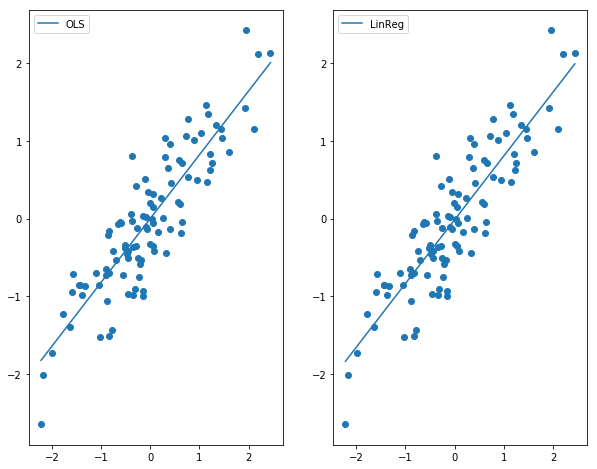

In [26]:
A = np.random.multivariate_normal([0, 0], [[1, 0.9], [0.9, 1]], size=(100,))
X = A[:, 0].reshape(-1, 1)
y = A[:, 1].reshape(-1, 1)
x_ls = np.linalg.lstsq(X, y)[0]
lr = LinearRegression().fit(X, y)
x_lr = lr.coef_

xx = np.linspace(X.min(), X.max(), 100)
yy_ls = xx * x_ls
yy_lr = lr.predict(xx.reshape(-1, 1))

plt.figure(figsize=(10, 8));
plt.subplot(121), plt.scatter(X.ravel(), y.ravel()), plt.plot(xx, yy_ls.ravel(), label="OLS"), plt.legend();
plt.subplot(122), plt.scatter(X.ravel(), y.ravel()), plt.plot(xx, yy_lr.ravel(), label="LinReg"), plt.legend();

# Underdetermined System of Equations


$$Ax = b \mid A \in I\!R^{m \times n} \mid m < n$$


# The Simplest Impossible Problem

Which two numbers have the mean 3?



Arithmetic mean as matrix multiplication

$ A = \begin{bmatrix}
0.5 & 0.5 \\
0 & 0
\end{bmatrix}$

$b = \begin{bmatrix}
3\\
0
\end{bmatrix} $


$x = \begin{bmatrix}
x_{1}\\
x_{2}
\end{bmatrix}$

Then solve
$Ax = b$

In [29]:
print("Ordinary Least Squares (L2 minimization):")
A = np.array([[0.5, 0.5], [0, 0]])
b = np.array([[3], [0]])
print(np.linalg.lstsq(A, b)[0])
print()
print("Linear Regression (L2 minimization):")
lr.fit(A, b)
print(lr.coef_)
print()
print("Lasso (L1 minimization):")
lasso = Lasso(alpha=0.0001)
lasso.fit(A, b)
print(lasso.coef_)

Ordinary Least Squares (L2 minimization):
[[3.]
 [3.]]

Linear Regression (L2 minimization):
[[3. 3.]]

Lasso (L1 minimization):
[5.9984 0.    ]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


## Vector Norms

A norm $p$ of a vector $\mathbf{x} \in I\!R^{n}$ is defined as:


$$ L_{p} = \bigg(\sum_{k=0}^{n-1} \left\lVert{x_{k}}\right\rVert^{p}\bigg)^{\frac{1}{p}}$$


*  For OLS / Regression, we've been minimizing $L_{2}$ (energy of the vector)
*  $L_{1}$ norm is the shortest path through the vector
*  $L_{0}$ norm is the sparsity of the vector*
*  Under conditions like RIP, $L_{1}$ == $L_{0}$

([], <a list of 0 Text yticklabel objects>)

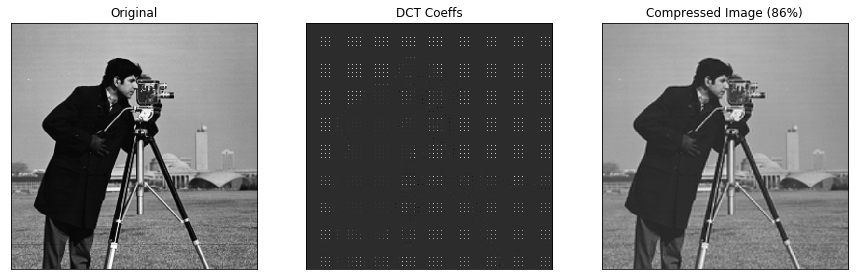

In [30]:
from skimage.data import camera
from skimage.util.shape import view_as_blocks


x = camera()
orgblocks = view_as_blocks(x, (8, 8))

rowaccum = []
for rowix in range(64):
    colaccum = []
    for colix in range(64):
        data = orgblocks[rowix, colix, ...]
        data = dct(dct(data.T).T)
        c_comp = np.zeros(data.shape)
        c_comp[:3, :3] = data[:3, :3]
        colaccum.append(c_comp)
    rowaccum.append(np.hstack(colaccum))
coefs = np.vstack(rowaccum)

cblocks = view_as_blocks(coefs, (8, 8))
rowaccum = []
for rowix in range(64):
    colaccum = []
    for colix in range(64):
        data = cblocks[rowix, colix, ...]
        data = idct(idct(data.T).T)
        colaccum.append(data)
    rowaccum.append(np.hstack(colaccum))
recons = np.vstack(rowaccum)


plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(x, cmap=plt.cm.gray)
plt.title('Original')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.subplot(132)
plt.imshow(coefs, cmap=plt.cm.gray)
plt.title('DCT Coeffs')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.subplot(133)
plt.imshow(recons, cmap=plt.cm.gray)
plt.title('Compressed Image (86%)')
plt.grid(False)
plt.xticks([])
plt.yticks([])

# Fourier Coefficients & Data Compression

As a linear algebra problem

Discrete Fourier Transform:

$$ X_{k} = \sum_{n = 0}^{N - 1} x_{n}e^{-2\pi ik\frac{n}{N}} \mid k \in [0, N - 1]$$

$$ \mathbf{X} = \mathbf{W}\mathbf{x} \mid W \in \mathbb{C}^{N \times N} \mid W_{mn} = e^{2\pi i \frac{mn}{N}} $$

$$ \begin{bmatrix}
X_{0}\\
X_{1}\\
\vdots\\
X_{N-1}\\
\end{bmatrix} = \begin{bmatrix}
e^{2\pi i \frac{0 \times 0}{N}} & e^{2\pi i \frac{0 \times 1}{N}} \ldots e^{2\pi i \frac{0 \times N}{N}}\\
e^{2\pi i \frac{1 \times 0}{N}} & e^{2\pi i \frac{1 \times 1}{N}} \ldots e^{2\pi i \frac{1 \times N}{N}}\\
\vdots\\
e^{2\pi i \frac{N \times 0}{N}} & e^{2\pi i \frac{N \times 1}{N}} \ldots e^{2\pi i \frac{N \times N}{N}}\\
\end{bmatrix}
\begin{bmatrix}
x_{0}\\
x_{1}\\
\vdots\\
x_{N - 1}
\end{bmatrix}$$

OR...

$$ b = Ax $$



A function $f = \sum \Psi c$ where $\Psi$ is a set of basis functions and $c$ are the coefficients.  
$f$ can be sampled as $b = \Phi f$, where $\Phi$ is the sampling operator  
For reconstruction, solve $Ax = b$ where $A = \sum\Phi\Psi$  
If solution worked, $x \approx c$  
Recover $f$ as $f = \Psi x$  


## DTMF Example

https://brocabrain.blogspot.com/2012/10/compressed-sensing-with-sklearn-dtmf.html  
https://github.com/jaidevd/scikit-signal/blob/master/compressed_sensing/DTMF_example/magic_reconstruction.ipynb  

I first read about compressed sensing about two years ago, on Cleve's Corner, a column which Cleve Moler, the founder of Mathworks, writes annually. The 2010 article was called "Magic Reconstruction: Compressed Sensing". Compressed (or compressive) sensing is immediately appealing for a number of reasons. It has all the features of a cool signal processing problem. It seems to beat the Shannon-Nyquist sampling theorem by making use of sparsity in real signals, and this sparsity begs the question - sparsity in which basis? This question in turn calls for some prior information about the data in question, which potentially leads to a wide range of other mathematical problems. (Perhaps a machine learning problem for detecting which basis are appropriate for a given set of signals, especially when prior information about signals is not available.)

But even without all this, as Moler points out, the real appeal of compressed sensing lies in the underlying matrix problem. This problem requires a great deal of rigour in linear algebra and convex optimization. I did get to those problems eventually, but initially I was more curious as to whether compressed sensing really worked, and I tried out the example in his post in Python. That's what this post is about.

The problem consists simply of creating a touchtone signal, trying to compress and decompress it, and checking whether the original signal and the reconstructed signal match acoustically. 

A reasonably reliable method of validating the compression and reconstruction is to listen to the original  signal and check if the reconstructed signal sounds similar. The scikits.audiolab package can be used to play sound straight from numpy arrays. 
 
We pick any two touchtone frequencies $f_1$ and $f_2$ (in this case 697 Hz and 1336 Hz, corresponding to the '5' key on the keypad), and play the following signal for an eighth of a second.
$f = \sin(2\pi f_1t) + \sin(2\pi f_1t)$
At a sampling rate of 4 kHz, it comes to 5000 samples. As per the example, we take 500 random samples of this signal.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


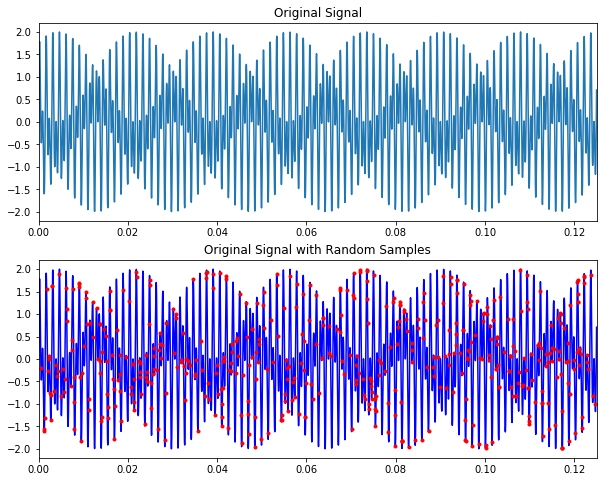

In [31]:
N = 5000
FS = 4e4
M = 500
f1, f2 = 697, 1336 # Pick any two touchtone frequencies
duration = 1./8
t = np.linspace(0, duration, duration*FS)
f = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t)
f = f.reshape(-1, 1)

# Displaying the test signal
plt.figure(figsize=(10, 8))
plt.subplot(211), plt.plot(t,f)
plt.xlim(0, 0.125)
plt.title('Original Signal')

# Randomly sampling the test signal
k = np.random.randint(0,N,(M,))
k = np.sort(k) # making sure the random samples are monotonic
b = f[k]
plt.subplot(212), plt.plot(t,f,'b', t[k],b,'r.')
plt.xlim(0, 0.125)
plt.title('Original Signal with Random Samples')

Audio(np.tile(f.ravel(), 10), rate=44100)

Since this is a simple, almost stationary signal, a simple basis like discrete cosines should suffice to bring out the sparsity.

Reconstructing the signal from the random samples with sklearn.linear_model.Lasso

In [38]:
D = dct(np.eye(N), axis=0)
A = D[k,:]
lasso = Lasso(alpha=0.001)
lasso.fit(A, b)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Here A is a matrix which contains a subset of 500 discrete cosine bases, and we need to solve $Ax=b$ for $x$. It is a nonlinear optimization problem and there are many solutions, but it turns out that the one that minimizes the $L_1$ norm of the solution gives the best estimate of the original signal. Since this is an optimization problem, it can be solved with many of the methods in scipy.optimize, say by taking the least squares solution of the equation (or the $L_2$ norm) as the first guess and minimizing iteratively. But I took the easier approach and used the Lasso estimator in the sklearn package, which is essentially a linear estimator that penalizes (regularizes) its weights in the $L_1$ sense. (A really cool demonstration of compressed sensing for images using Lasso is here).

As can be seen through the plots, most of the coefficients of the lasso estimator as zeros. It is the discrete cosine transform of these coefficients that is the reconstructed signal. Since the coefficients are sparse, they can be compressed into a scipy.sparse matrix. As it turns out, the compressed matrix is about 90% sparse. Thus, we have managed to reconstruct the signal from only 10% of its samples.

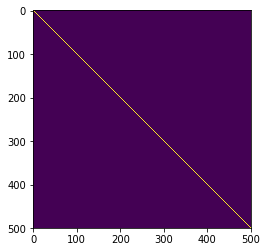

In [43]:

plt.imshow(np.dot(A,np.transpose(A))); # Matrix A should be isotropic, i.e. cov(A) should be the identity matrix.


The matrix A should be isotropic, i.e.: $E(AA^T)=I$ Or, the covariance of A should be the identity matrix.

Text(0.5, 1.0, 'Reconstucted Signal')

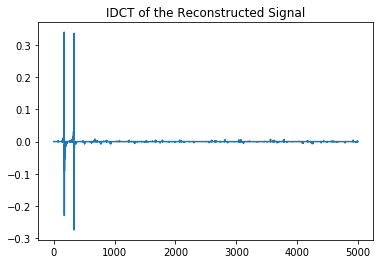

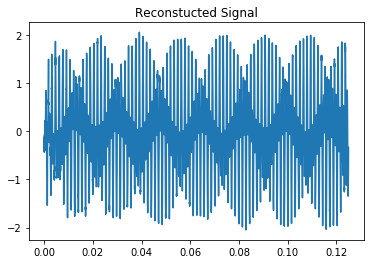

In [44]:
# Plotting the reconstructed coefficients and the signal
plot(lasso.coef_)
title('IDCT of the Reconstructed Signal')
recons = dct(lasso.coef_.reshape((N,1)),axis=0)
figure()
plot(t,recons)
title('Reconstucted Signal')

In [45]:
recons_sparse = coo_matrix(lasso.coef_)
sparsity = 1 - float(recons_sparse.getnnz())/len(lasso.coef_)
print(sparsity)

0.902



Thus, the coefficients required to construct the original signal can be stored in a matrix that is 90% sparse! Optionally, we can play out the audio in both the reconstructed signal and the original signal to verify if they are the same.

Sparsity: 9.8%


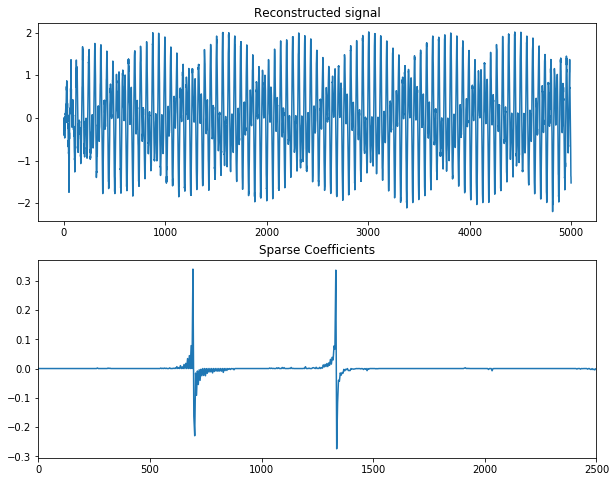

In [40]:

print( "Sparsity: {}%".format((lasso.coef_ != 0).sum() / float(lasso.coef_.shape[0]) * 100))

recons = idct(lasso.coef_)
plt.figure(figsize=(10, 8))
plt.subplot(211), plt.plot(recons)
plt.title('Reconstructed signal')
plt.subplot(212), plt.plot(np.linspace(0, FS/2, N), lasso.coef_), plt.xlim(0, 2500)
plt.title('Sparse Coefficients')

Audio(np.tile(recons, 10),  rate=44100)

As can be seen through the plots, most of the coefficients of the lasso estimator as zeros. It is the discrete cosine transform of these coefficients that is the reconstructed signal. Since the coefficients are sparse, they can be compressed into a scipy.sparse matrix.

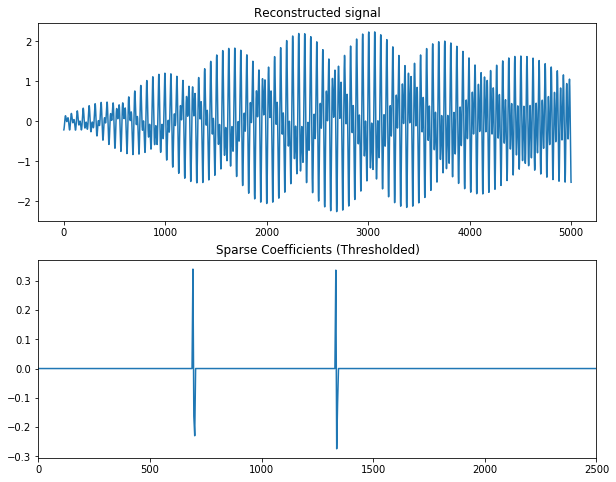

In [34]:
coefs = lasso.coef_.copy()
coefs[np.abs(coefs) <= 0.1] = 0
recons_th = idct(coefs)

plt.figure(figsize=(10, 8))
plt.subplot(211), plt.plot(recons_th)
plt.title('Reconstructed signal')
plt.subplot(212), plt.plot(np.linspace(0, FS/2, N), coefs), plt.xlim(0, 2500)
plt.title('Sparse Coefficients (Thresholded)')

Audio(np.tile(recons_th, 10),  rate=44100)

Further...

The entire reconstruction depends on sparsity and prior information about the signal. That's probably why wavelets are a popular choice for bases in compressed sensing applications, since using wavelets is equivalent to imposing a prior basis on signals. The important question to answer in all compressed sensing problems is - in which basis is the signal sparse? An interesting follow up question would be - what if the bases are intrinsic mode functions? How does one perform empirical mode decomposition such that the decomposition is sparse? And that's only the tip of the iceberg. Prior information is exactly what is absent in intrinsic mode functions! Examining IMFs as bases for sparsity in signals should be an interesting problems, given that they complement wavelets nicely.

## Random Sampling of a Time Signal

http://www.gallamine.com/2014/02/a-brief-introduction-to-compressed.html  
https://gist.github.com/gallamine/9223302  



Suppose we have a time signal. This signal is not known, but we do know something about it - namely that it's *sparse* in *some* domain. Maybe that means it's only made up of certain frequencies, so when you look at the signal in the frequency domain it's mostly zeros, with a few non-zero values intermixed. 

Let's call this **unknown** signal $X$. Now, even though we don't know the whole signal, we can still make observations of it, or samples. Sampling could be expensive, time consuming or not technilogically feasible, which is why we want to limit the number of observations or samples to as small a number as possible.

Furthermore, when we make observations of the signal we aren't going to do it in a repeting pattern (*e.g.* every 10th sample). No, instead we're going to **randomly** sample the data.

Let's try this in Python:

In [46]:
%matplotlib inline
from matplotlib.pyplot import plot, show, figure, title
import matplotlib as plt
import numpy as np

from scipy.fftpack import dct, idct,fft
from scipy.sparse import coo_matrix

In [47]:
Fs = 40e3  #Sample rate
duration = 1./8
N_samps = int(np.floor(duration*Fs))
M = 250   # Number of compressed "basis" functions - we're going from N_samps to M samps.
f1 = 200
f2 = 3950

print("Compression ratio {0}".format(M/N_samps))
t = np.linspace(0,duration,N_samps)

Compression ratio 0.05


Text(0, 0.5, 'X(t)')

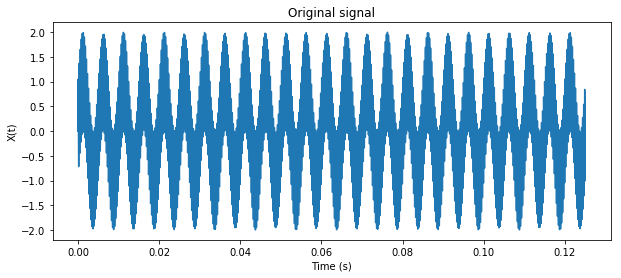

In [48]:
X = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t)

figure(figsize=[10,4])
plot(t,X)
title('Original signal')
plt.pyplot.xlabel('Time (s)')
plt.pyplot.ylabel('X(t)')

Now we're going to chose random points in time from which to sample the data. 

In [49]:
yi = np.random.randint(0,N_samps,(M,))
yi = np.sort(yi)
Y = X[yi]

Text(0, 0.5, 'X(t) and X(random sample)')

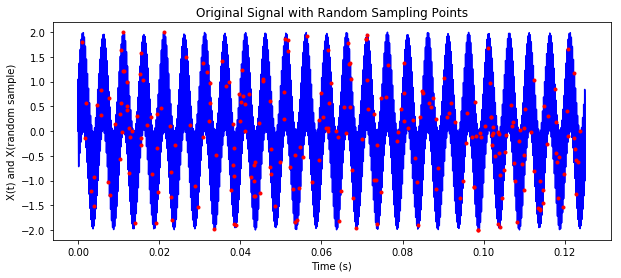

In [50]:
figure(figsize=[10,4])
plot(t,X,'b',t[yi],Y,'r.')
title('Original Signal with Random Sampling Points')
plt.pyplot.xlabel('Time (s)')
plt.pyplot.ylabel('X(t) and X(random sample)')

Now we know two things, A) we know our samples, $X(t_{samps})$ and we know the sample times, $t_{samps}$. Using this we can transform our samples into the *sparse domain*. In this case, we've chosen the Discrete Cosine Domain. This could just as easily been the Discrete Fourier domain. In fact, you might want to try both just to see the differences.

We're computing the DCT for each of the possible sample points (N_samps) and then only choosing the ones we actually sampled at. $A$ is now the DCT basis functions corresponding to our random sample times *in the time domain*. It is literally a matrix where each column corresponds a cosine function at a different frequency. The frequencies correspond to the sample times we chose randomly. In other words, $A$ now represents what those samples look like in another domain. 

In [51]:
D = dct(np.eye(N_samps))   # Construct the DCT basis functions for each of the frequencies
A = D[yi]                  # Downsample based on our random sampling

In [52]:
np.shape(A)

(250, 5000)

This means we now *know* $A$, based on the sample times, and $Y$, which is our sampled data. We also know that the original data, $X$ was sparse in the DCT domain. We'll call the sparse DCT version of $X$, $\tilde X$. *We are now trying to solve for $\tilde X$ based on this knowledge*. In other words we're trying to find the solution to $\tilde X$ that makes the equation $A\tilde X = Y$ true. $A$ is the translation from our random time samples into the DCT domain, $\tilde X$ is in DCT domain and is presumed sparse, and $Y$ is a time domain signal. In other words, we're trying to solve, $\min (Y - A\tilde X)$ in some fashion.

We can use the LASSO to find the sparse solution. It's solving:

$$ c * ||Y - A\tilde X||^2_2 + alpha * ||\tilde X||_1 $$

where $c$ is some constant based on the number of samples, and $||\tilde X||_1 $ is the $\ell_1$ norm, which assures that the solution to $\tilde X$ is sparse.

In [53]:
from sklearn.linear_model import Lasso   # http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Solution is %96.02000000000001 sparse


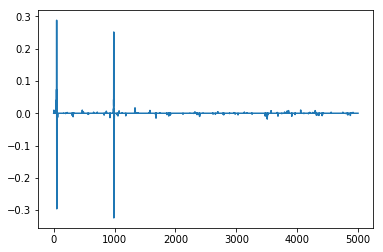

In [54]:
lasso = Lasso(alpha=0.01)
lasso.fit(A,Y)

plot(lasso.coef_)

sparseness = np.sum(lasso.coef_ == 0)/N_samps
print("Solution is %{0} sparse".format(100.*sparseness))

The plot above shows how many DCT coefficients in the final solution are non-zero. Remember, this solution is what we approximate $X$ to be in the DCT domain. You can see that there are very very few coefficients that are not zero. To find out what we estimate the true signal to be in the time domain, $\hat X$, we take the Inverse Discrete Cosine Transform (IDCT) of the LASSO solution.

In [55]:
Xhat = idct(lasso.coef_)

Text(0.5, 1.0, 'Error delta')

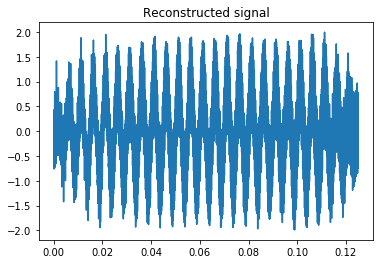

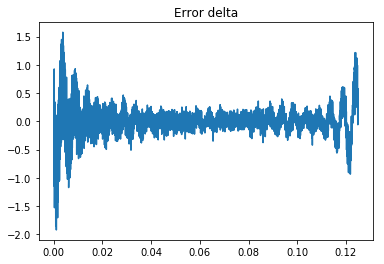

In [56]:
figure()
plot(t,Xhat)
title('Reconstructed signal')
figure()
plot(t,Xhat-X)
title('Error delta')

The plots above show the reconstructed signal in the time domain and the reconstructed signal, $\hat X$ versus the original signal, $X$. You can see how the error tends to go up at the beginning and end of the signal. I presume this is due to the fact that we don't have unlimited data and are taking a window of fixed length.

Text(0.5, 1.0, 'Original and reconstructed signal plotted together (green is orig)')

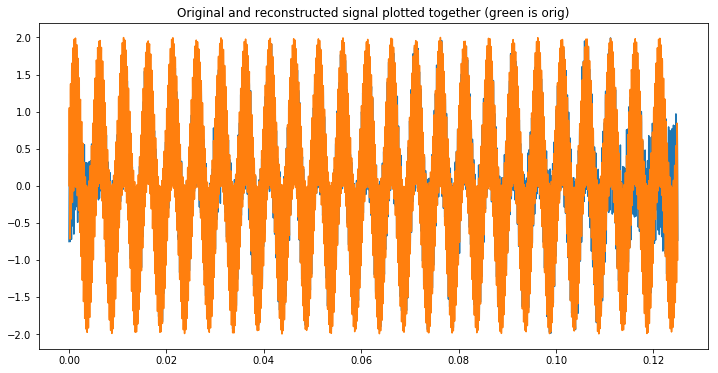

In [57]:
figure(figsize=[12,6])
plot(t,Xhat)
plot(t,X)
title("Original and reconstructed signal plotted together (green is orig)")

Don't forget that this reconstruction is achieved using only a small fraction of the total sample. The compression ratio is:

In [58]:
print("Signal is reconstructed using only %{0} of the data!".format(100.*M/N_samps))

Signal is reconstructed using only %5.0 of the data!


It's a little hard to tell what's going on in the figure above. A better way to look at things would be to look at the signal in the frequency domain where, since that's where it's sparse.

Text(0, 0.5, 'Power (dB)')

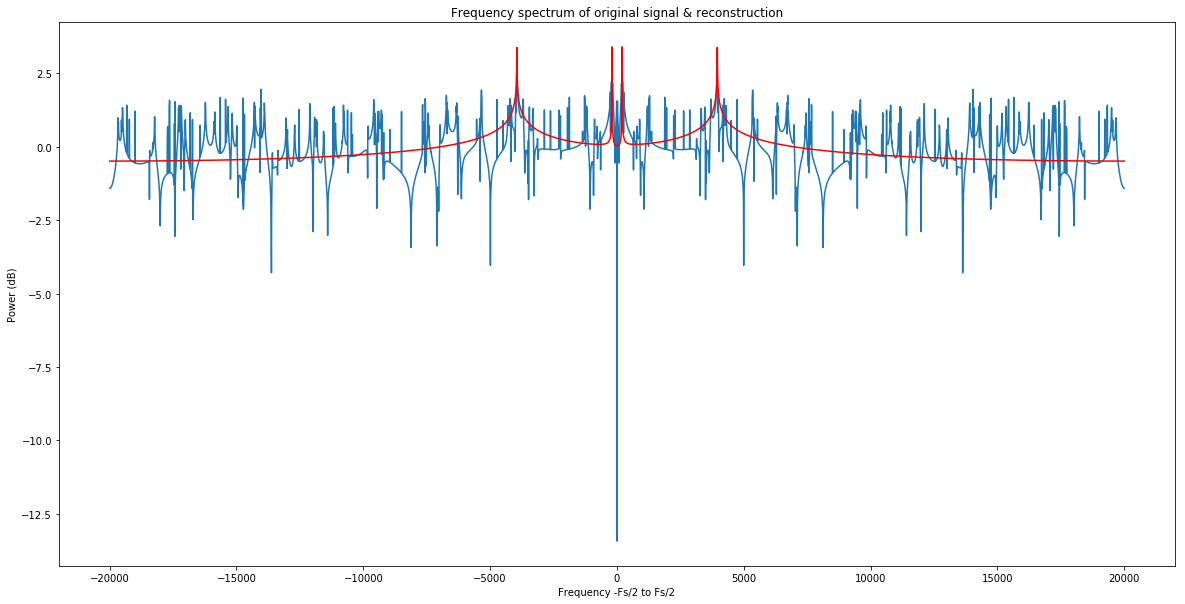

In [59]:
f = np.linspace(-Fs/2,Fs/2,N_samps)
figure(figsize=[20,10])
plot(f,np.log10(np.fft.fftshift(np.abs(fft(Xhat)))))
title("Frequency spectrum of original signal & reconstruction")
plot(f,np.log10(np.fft.fftshift(np.abs(fft(X)))),'r')
plt.pyplot.xlabel('Frequency -Fs/2 to Fs/2')
plt.pyplot.ylabel('Power (dB)')